# Overview 
Sparkify is a music streaming service just as Spotify and Pandora.

The data provided is the user log of the service, having demographic info, user activities, timestamps and etc. We try to analyze the log and build a model to identify customers who are highly likely to quit using our service, and thus, send marketing offers to them to prevent them from churning.

We use F1 score to measure of model performance because we need precision and recall at the same time as we don't want to miss too many customers who are likely to churn whilst we don't want to waste too much on those who are not likely to churn.

We performed EDA to establish features, and train several machine learning classification models.

The model we built and selected has a F1 score of 0.800, which is 16% higher than sending everybody offers. There is also a short article about this project posted here.

The problem that I will attempt to solve will be to predict customer churn in advance and I will be using spark (PySpark) and the Gradient boosting models classification.

In [1]:
# Import libraries
from pyspark.sql import SparkSession

In [2]:
# Create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load and Clean Dataset

In [3]:
# Load the data and check the schema
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
# Check for missing values
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



We can see that, the numbers of missing values in the columns of gender, firstName, lastName, registration, location, and userAgent are the same, which makes sense since these are related to the user information, but there is no missing values in the userID and sessionID columns which should have the similar number of missing values as they are also related to the user information, so further examinations on empty entries should be conducted. 

In [7]:
# Check the columns with the same number of missing values
df.select(df.columns).where(isnan('gender') | col('gender').isNull()).show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [8]:
df.filter(df['sessionId']=='').count()

0

In [9]:
df.filter(df['userID']=='').count()

8346

The number of empty entries in the userID column is the same of those numbers of missing values. Since the empty userID entry may be a result from unlogged user, these rows are not significant for our further analysis, the next step will be removing the rows with empty entries in the userID column and check the missing values again.

In [10]:
df_clean = df.filter(df['userID']!='')

df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Now, we have no missing values in the columns related to user information. The missing values in the song-related information columns, including artist, length, and song, are reasonable as many events don't involve listening to a song and these can be treated as a feature later in the modeling, so we will keep these rows in the dataframe now.

In [11]:
# Check the unique values in the categorical columns
df.select('auth').distinct().show(), df.select('level').distinct().show(), df.select('method').distinct().show(), 
df.select('page').distinct().show(), df.select('status').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



(None, None)

In [12]:
# Check the unique values in the categorical columns in the cleaned dataset
df_clean.select('auth').distinct().show(), df_clean.select('level').distinct().show(), df_clean.select('method').distinct().show(), 
df_clean.select('page').distinct().show(), df_clean.select('status').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



(None, None)

It is interesting to see that after removing those rows with missing/empty values in userID, there less categeories in the columns of auth and page, which are Logged Out/Guest, and Login/Register/Submit Registration as expected. Only guests or those logged out don't have user information and logged-in users can't log in again or register for an account.

# Exploratory Data Analysis

### Initial Analysis

In [129]:
# Convert the ts and registration column to regular time format
from pyspark.sql.functions import udf
import datetime

time_transfer = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df_clean = df_clean.withColumn('time', time_transfer(df['ts']))
df_clean = df_clean.withColumn('registrationTime', time_transfer(df['registration']))

In [14]:
df_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57', registrationTime='2018-09-28 22:22:42')

In [15]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- registrationTime: string (nullable = true)



In [16]:
df_clean.count()

278154

In [17]:
# Check the number of users in the data
df_clean.select('userID').dropDuplicates().count()

225

In [18]:
df_clean.select('userAgent').distinct().count()

56

In [19]:
df_clean.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [20]:
# Check the statistics of the numerical column of length
df_clean.select('length').describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



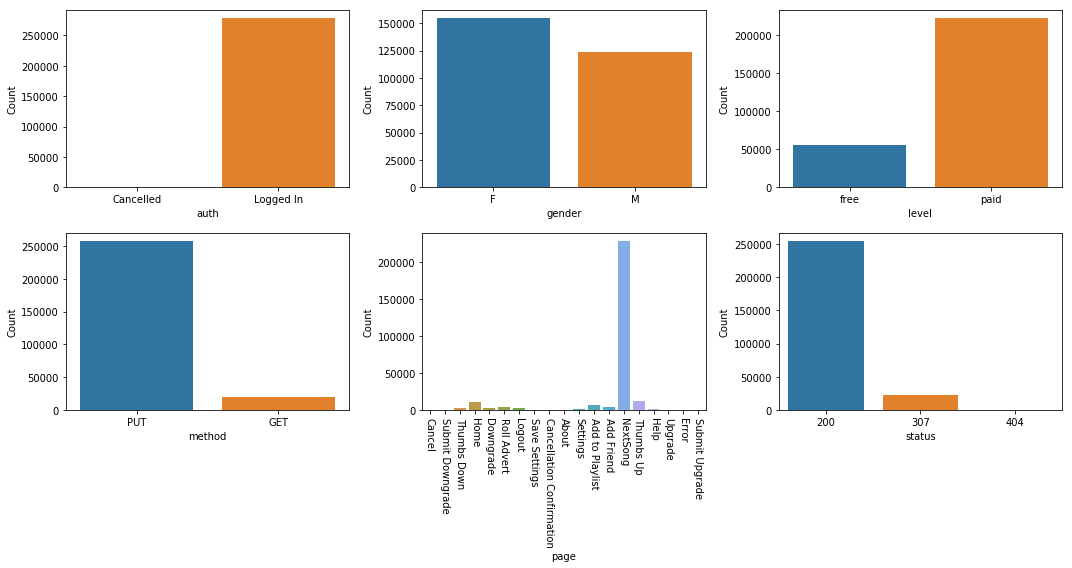

In [38]:
# Visualize the distributions of the categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ['auth', 'gender', 'level', 'method', 'page', 'status']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (15, 8))

axs = axs.ravel()

i = 0

for col in cat_cols:
    temp_df = df_clean.groupBy(col).count().toPandas()
    sns.barplot(temp_df[col], temp_df['count'], ax = axs[i])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')
    axs[i].legend(loc=0)
    if col == 'page':
        axs[i].tick_params(axis='x', rotation = -90)
    i += 1
    
plt.tight_layout()
plt.show()

From the observations above, one most significant finding is that for most of the categorical columns, the distribution is strongly skewed.

### Define Churn

Create a column `Churn` to use as the label for the model. Here, I chose to use the `Cancellation Confirmation` event in the `page` column to define the churn, which happen for both paid and free users.

In [22]:
df_clean.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [23]:
df_clean.filter((df['auth']!='Cancelled') & (df['page']=='Cancellation Confirmation')).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|time|registrationTime|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+----------------+



In [24]:
df_clean.filter(df['page']=='Cancellation Confirmation').select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
+---------+



In [25]:
df_clean.filter(df['page']=='Cancellation Confirmation').count()

52

In [26]:
df_clean.filter(df['page']=='Cancellation Confirmation').select('userID').dropDuplicates().count()

52

We observe that no duplicate user ID is present with the `Cancellation Confirmation` event and only those with a `Cancelled` auth status can have the `Cancellation Confirmation` event. Then,we will define the churn column, which is labeled 1 if the user ID in the same row has ever performed a `Cancellation Confirmation` event.

In [27]:
# Define the list of the user IDs who have ever had the cancellation confirmation event
user_churned = df_clean.filter(df['page']=='Cancellation Confirmation').select('userID').dropDuplicates()
user_churned_list = [r['userID'] for r in user_churned.collect()]

In [28]:
# Create the churn column 
from pyspark.sql.types import IntegerType

# Define the udf to extract the churn label
is_churn_udf = udf(lambda x: 1 if x in user_churned_list else 0, IntegerType())
df_clean = df_clean.withColumn('churn', is_churn_udf('userID'))

In [29]:
df_clean.filter(df_clean['churn']==0).count()

233290

In [30]:
df_clean.count()

278154

In [31]:
# df_with_target = df_clean.withColumn('churn', df['userID'].isin(user_churned_list))
# df_with_target.filter(df_with_target['churn']==False).count()

In addition, downgrading may be another interesting target variable to study, which is reflected by the `Submit Downgrade` event in the `page` column. We'll also include it here using the similar method above.

In [32]:
df_clean.filter(df['page']=='Submit Downgrade').select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Logged In|
+---------+



In [33]:
# downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
# df = df.withColumn("downgrade_value", downgrade_value("page"))

# dg_window = Window.partitionBy('UserId')
# df = df.withColumn("user_downgrade", max('downgrade_value').over(dg_window))

In [34]:
user_downgrade = df_clean.filter(df['page']=='Submit Downgrade').select('userID').dropDuplicates()
user_downgrade_list = [r['userID'] for r in user_downgrade.collect()]

In [35]:
is_downgrade_udf = udf(lambda x: 1 if x in user_downgrade_list else 0, IntegerType())
df_clean = df_clean.withColumn('downgrade', is_downgrade_udf('userID'))

In [36]:
df_clean.dropDuplicates(['userID']).select('auth', 'level', 'page', 'userId', 'churn', 'downgrade').show()

+---------+-----+--------+------+-----+---------+
|     auth|level|    page|userId|churn|downgrade|
+---------+-----+--------+------+-----+---------+
|Logged In| free|NextSong|100010|    0|        0|
|Logged In| free|NextSong|200002|    0|        0|
|Logged In| free|NextSong|   125|    1|        0|
|Logged In| paid|    Home|   124|    0|        0|
|Logged In| paid|    Home|    51|    1|        0|
|Logged In| free|NextSong|     7|    0|        0|
|Logged In| paid|    Home|    15|    0|        0|
|Logged In| paid|NextSong|    54|    1|        1|
|Logged In| free|    Home|   155|    0|        0|
|Logged In| paid|NextSong|100014|    1|        0|
|Logged In| free|NextSong|   132|    0|        0|
|Logged In| free|    Home|   154|    0|        0|
|Logged In| free|    Home|   101|    1|        0|
|Logged In| free|    Home|    11|    0|        1|
|Logged In| free|    Home|   138|    0|        0|
|Logged In| paid|NextSong|300017|    0|        0|
|Logged In| free|NextSong|100021|    1|        0|


### Explore Data
With the churn (target column) defined, it will be helpful to perform some further exploratory data analysis to see the difference in behaviors for users who stayed vs users who churned. We'll start with the patterns of the columns we currently have based on whether the user churned or not.

In [115]:
churn_count = df_clean.dropDuplicates(['userID']).groupBy('churn').count().toPandas()
churn_ratio = churn_count['count'][0] / (churn_count['count'].sum())
print('There are {} churned users and {} non-churned users, the ratio of churned users is {:.2f}%.'.format(churn_count['count'][0],
                                                                                                      churn_count['count'][1],
                                                                                                      churn_ratio * 100))

There are 52 churned users and 173 non-churned users, the ratio of churned users is 23.11%.


In [128]:
def vis_dist_pattern(df, drop_label, x_label):
    '''
    Function to visualize the difference in distribution based on some categorical feature(s) in the dataset
     
    Args:
        df: a spark Dataframe
        drop_label: a list of string(s), the name(s) of the column(s) to drop the duplicates
        x_label: a string, the name of the column for the x-axis
        
    Returns:
        None
    '''
    fig, ax = plt.subplots(figsize=(6, 4))
    df_temp = df.dropDuplicates(drop_label).groupBy([x_label, 'churn']).count().toPandas()
    sns.barplot(x=x_label, y='count', hue='churn', data=df_temp)
    # plt.savefig('./figs/comp_%s_on_%s.png' % (x_label, base_name), dpi = 300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

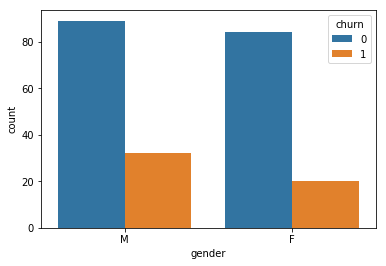

In [51]:
vis_dist_pattern(df_clean, ['userID'], 'gender')

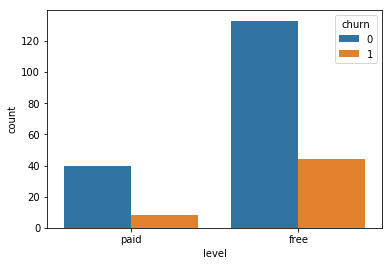

In [90]:
vis_dist_pattern(df_clean, ['userID'], 'level')

In [163]:
df_status = df_clean.groupBy(['churn','status']).count().toPandas()
tot_churn_status = df_status[df_status['churn'] == 1]['count'].sum()
tot_nonchurn_status = df_status[df_status['churn'] == 0]['count'].sum()
df_status['dist_by_churn'] = df_status.apply(lambda x: x['count'] / tot_churn_status * 100 
                                             if x['churn'] == 1 else x['count'] / tot_nonchurn_status * 100, axis=1)

df_status.sort_values(['churn', 'status'], axis=0)

,churn,status,count,dist_by_churn
4,0,200,213581,91.551717
5,0,307,19489,8.353980
2,0,404,220,0.094303
0,1,200,41137,91.692671
3,1,307,3695,8.236002
1,1,404,32,0.071327


As each user has the unique values in the `gender` and `level` column, we keep only one record of each user and check the specific patterns of these two columns.<br/>
We can see that, there tend to be more non-churned male users as well as churned male users than female users, with a higher ratio of churning for male users. Also, there is a higher chance for free users to churn and the total amount of free users are much larger than paid users.<br/>
The distribution of the `status` column is very similar for two groups of users (seems like random events), so we should probably remove this feature later (as well as the `method` column).<br/>
The `page` column is of great interests and since each user can have multiple events, we should next check the distributions of different events based on whether the user experienced the event churned.

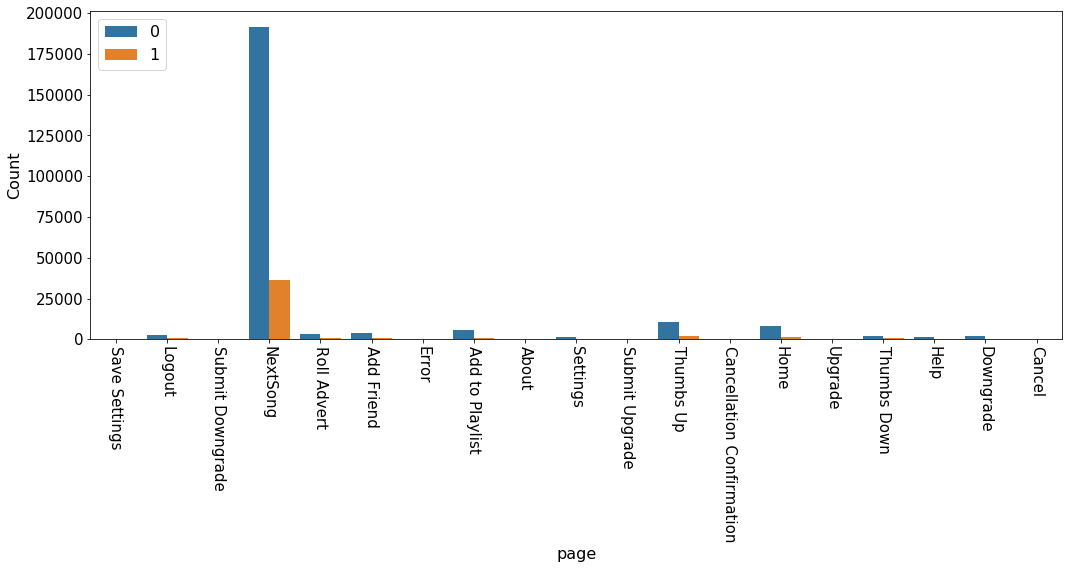

In [92]:
fig, ax = plt.subplots(figsize = (15, 8))
df_temp = df_clean.groupBy(['churn','page']).count().toPandas()
sns.barplot(x='page', y='count', hue='churn', data=df_temp, ax=ax)
ax.set_ylabel('Count', fontsize = 16)
ax.set_xlabel('page', fontsize = 16)
ax.tick_params(axis='y', labelsize = 15)
ax.tick_params(axis='x', labelsize = 15, rotation = -90)
ax.legend(loc = 0, fontsize = 16)
plt.tight_layout()
plt.show()

In [118]:
# Calculate the ratio of the NextSong of unchunred users
df_temp[df_temp['page'] == 'NextSong']['count'].iloc[1] / df_temp[df_temp['page'] == 'NextSong']['count'].sum()

0.15954723201290616

Apparently, churned users has much less actions of `NextSong`. Althought this may be resulted from the smaller total amount of churned, we can check the ratio of `NextSong` of unchunred users here, which is about 16% and smaller than the ratio of the churned users of around 21%, so it still seems to have an effect from this event. And due to the large numbers of this event, other events may not be so clear, so we'll remove this column and take the unbalanced user numbers into consideration to re-check the patterns.

In [119]:
# Take the unbalanced number of churned/non-churned users into consideration
df_temp['balanced'] = df_temp.apply(lambda x: x['count'] / churn_ratio if x['churn'] == 1 else x['count'], axis=1)

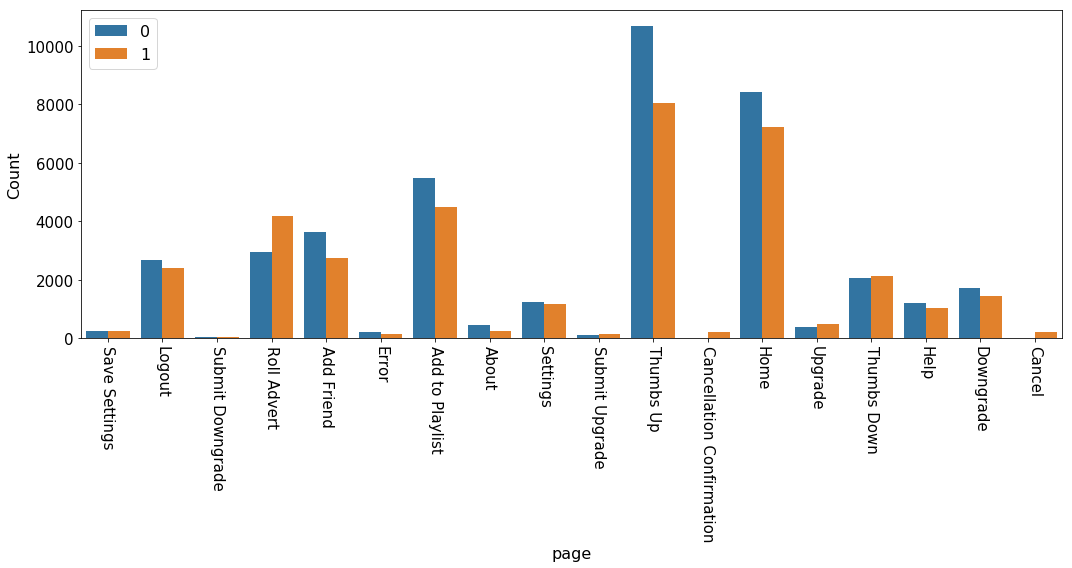

In [117]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.barplot(x='page', y='balanced', hue='churn', data=df_temp[df_temp['page']!='NextSong'], ax=ax)
ax.set_ylabel('Count', fontsize = 16)
ax.set_xlabel('page', fontsize = 16)
ax.tick_params(axis='y', labelsize = 15)
ax.tick_params(axis='x', labelsize = 15, rotation = -90)
ax.legend(loc = 0, fontsize = 16)
plt.tight_layout()
plt.show()

In [224]:
def vis_dist_percentage(df, col):
    '''
    Function to visualize the distribution patterns in percentage based on two user groups in the dataset
     
    Args:
        df: a spark Dataframe
        col: a string, the name of the column to visualize
        
    Returns:
        None
    '''
    df_temp = df.groupBy(['churn',col]).count().toPandas()
    tot_churn_events = df_temp[df_temp['churn'] == 1]['count'].sum()
    tot_nonchurn_events = df_temp[df_temp['churn'] == 0]['count'].sum()
    df_temp['percentage_by_churn'] = df_temp.apply(lambda x: x['count'] / tot_churn_events * 100 
                                                   if x['churn'] == 1 else x['count'] / tot_nonchurn_events * 100, axis=1)
    fig, ax = plt.subplots(figsize = (15, 8))
    
    sns.barplot(x=col, y='percentage_by_churn', hue='churn', data=df_temp, ax=ax)
    ax.set_ylabel('Percentage', fontsize = 16)
    ax.set_xlabel(col, fontsize = 16)
    ax.tick_params(axis='y', labelsize = 15)
    ax.tick_params(axis='x', labelsize = 15, rotation = -90)
    ax.legend(loc = 0, fontsize = 16)
    plt.tight_layout()
    plt.show()

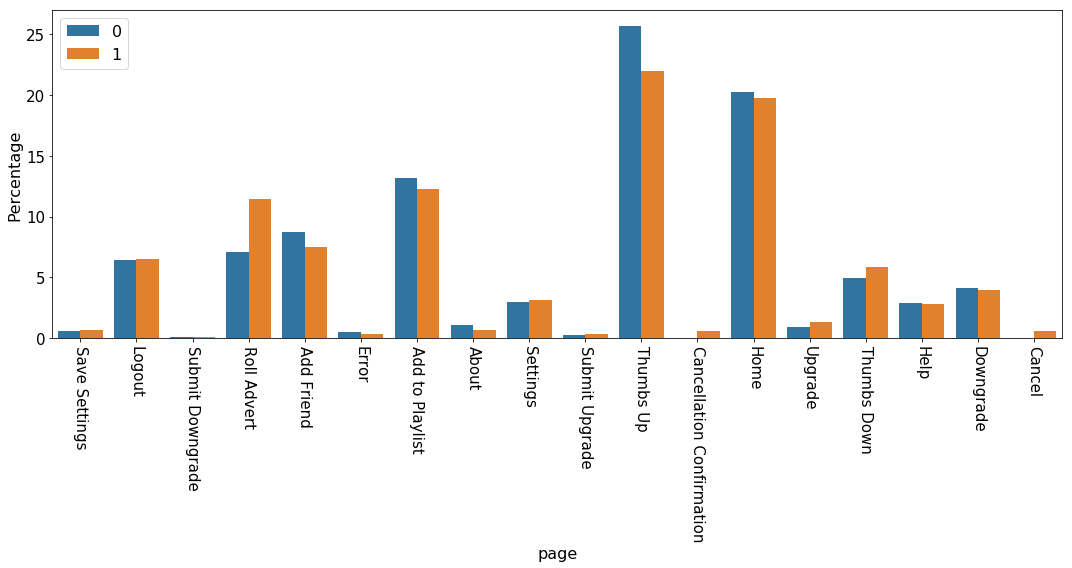

In [225]:
vis_dist_percentage(df_clean.filter(df_clean['page']!='NextSong'), 'page')

The two plots above have a similar trend, except for the `Logout`, `Home`, `Help`, and `Downgrade` events, which the trend is reversed, but since these events are originally quite similar for churned/non-churned users, such observation is fine. We can see that the most significant effects are from the `Roll Advert`, `Thumbs Up`, and `Thumbs Down` events as well as possible `Add Friend` and `Add to Playlist` events.
In these events, `Roll Advert` and `Thumbs Down` are positively related to churn while others are negatively related.<br/>
For the next step, we'll deal with the text info from the data, such as information from the `artist`, `location` and `userAgent` columns.

In [164]:
df_clean.select('artist').distinct().count()

17656

Too many possible artists, we'll firstly leave this out and check the other two columns.

In [168]:
df_clean.select('location').distinct().count()

114

In [169]:
df_clean.select('location').distinct().show(20, False)

+---------------------------------------+
|location                               |
+---------------------------------------+
|Gainesville, FL                        |
|Atlantic City-Hammonton, NJ            |
|Deltona-Daytona Beach-Ormond Beach, FL |
|San Diego-Carlsbad, CA                 |
|Cleveland-Elyria, OH                   |
|Kingsport-Bristol-Bristol, TN-VA       |
|New Haven-Milford, CT                  |
|Birmingham-Hoover, AL                  |
|Corpus Christi, TX                     |
|Dubuque, IA                            |
|Las Vegas-Henderson-Paradise, NV       |
|Indianapolis-Carmel-Anderson, IN       |
|Seattle-Tacoma-Bellevue, WA            |
|Albany, OR                             |
|Winston-Salem, NC                      |
|Bakersfield, CA                        |
|Los Angeles-Long Beach-Anaheim, CA     |
|Minneapolis-St. Paul-Bloomington, MN-WI|
|San Francisco-Oakland-Hayward, CA      |
|Phoenix-Mesa-Scottsdale, AZ            |
+---------------------------------

In [174]:
# Extract the state from the location
get_state_udf = udf(lambda x: x.split(',')[1].strip())
df_clean = df_clean.withColumn('state', get_state_udf('location'))

In [175]:
df_clean.select('state').distinct().count()

58

In [214]:
df_clean.select('state').distinct().show(5)

+-----+
|state|
+-----+
|UT-ID|
|   AZ|
|   SC|
|GA-AL|
|   LA|
+-----+
only showing top 5 rows



In [193]:
df_clean.select('userAgent').distinct().count()

56

In [194]:
df_clean.select('userAgent').distinct().show(20, False)

+-------------------------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                 |
|"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                   |
|Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0                                                                 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |
|"Mozi

In [198]:
trial_str = df_clean.select('userAgent').distinct().collect()[0][0]
trial_str

'"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'

In [212]:
pattern = r'\(([^\(\)]*)\)'
re.findall(pattern, trial_str)[0].split(';')[0]

'Macintosh'

In [220]:
# Extract the platform from the userAgent
import re
get_os_udf = udf(lambda x: re.findall(pattern, x)[0].split(';')[0])
df_clean = df_clean.withColumn('platform', get_os_udf('userAgent'))

In [221]:
df_clean.select('platform').distinct().count()

10

In [222]:
df_clean.select('platform').distinct().show()

+--------------+
|      platform|
+--------------+
|          iPad|
|           X11|
|Windows NT 6.3|
|        iPhone|
|Windows NT 6.2|
|     Macintosh|
|Windows NT 5.1|
|    compatible|
|Windows NT 6.0|
|Windows NT 6.1|
+--------------+



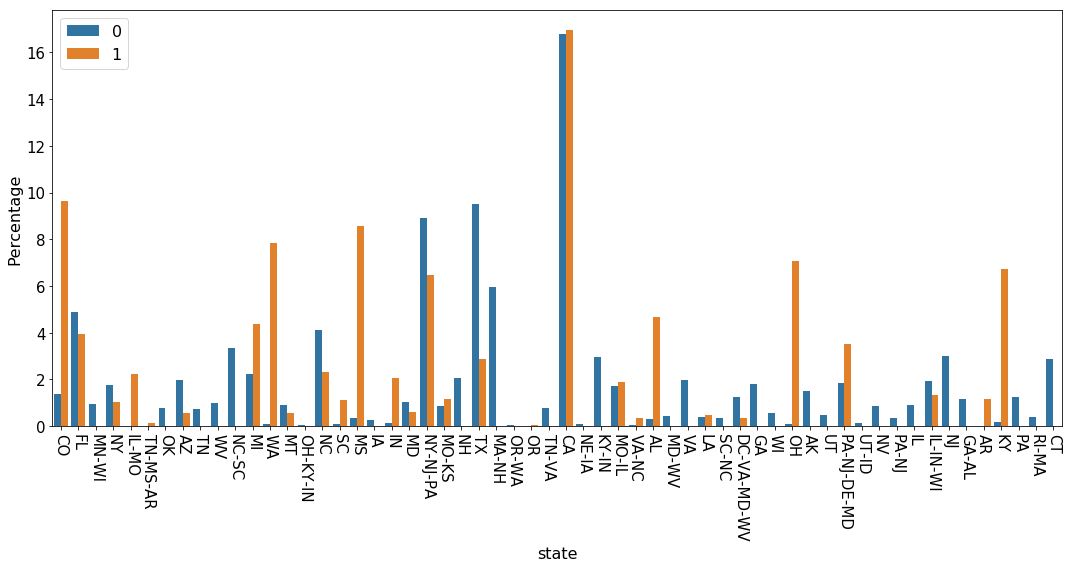

In [226]:
vis_dist_percentage(df_clean, 'state')

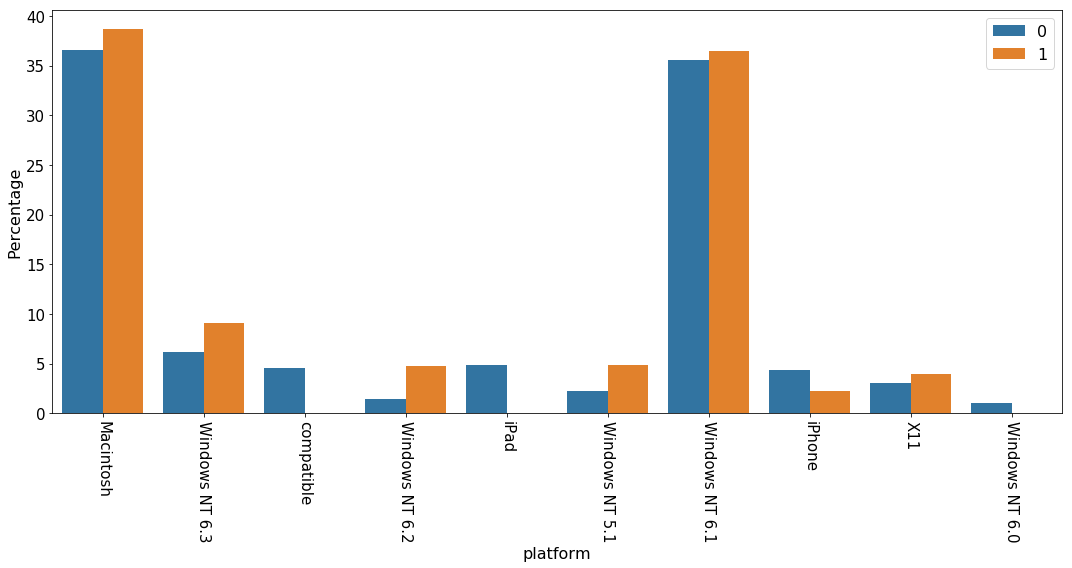

In [227]:
vis_dist_percentage(df_clean, 'platform')

We can observe some helpful patterns above. For the location-based distribution, it is interesting to find that users in some states like CO, MI, WA, MS, AL, OH, and KY contribute great to the churned group, while they contribute minor in the non-churned group.<br/>
For the platform users used, the overall distribution is similar, one interesting finding is that users using iPad and Windows NT 6.0 didn't churn. The majority of the users use Macintosh and Windows NT 6.1.

After these direct observations from the data, the next step will be exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [141]:
# Check the range of the time of the events
max_time = df_clean.groupBy().max('ts').collect()[0][0]
min_time = df_clean.groupBy().min('ts').collect()[0][0]
print('max_time: {}, min_time: {}.'.format(datetime.datetime.fromtimestamp(max_time / 1000).strftime('%Y-%m-%d %H:%M:%S'),
                                           datetime.datetime.fromtimestamp(min_time / 1000).strftime('%Y-%m-%d %H:%M:%S')))

max_time: 2018-12-03 01:11:16, min_time: 2018-10-01 00:01:57.


It seems that all these data are collected in the time interval from October 2018 to the beginning of December 2018, we can analyze the pattern based on the hours, weekday, and month.

In [ ]:
from pyspark.sql.functions import udf
import datetime

time_transfer = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df_clean = df_clean.withColumn('time', time_transfer(df['ts']))
df_clean = df_clean.withColumn('registrationTime', time_transfer(df['registration']))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.